In [1]:
%pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

import os
import time
import copy

import torch
import torchvision
import transformers
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [4]:
def log_debug(*args, **kwargs):
    if DEBUG:
        print(*args, **kwargs)

In [5]:
class BookNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')
        self.roberta = transformers.RobertaModel.from_pretrained('roberta-base')
        self.effnet = timm.create_model('efficientnetv2_rw_m', pretrained=True)
        self.effnet.classifier = nn.Identity()
        
        self.roberta = self.roberta.to(device)
        self.effnet = self.effnet.to(device)
        
        self.classifier = nn.Sequential(
            nn.Linear(768+2152, 2048),
            nn.Dropout(p=0.3),
            nn.Linear(2048, 512),
            nn.Dropout(p=0.3),
            nn.Linear(512, 30)
        )
        
    def forward(self, batch):
        idxs, covers, titles, *_ = batch
        tok_titles = self.tokenizer(list(titles), padding=True, truncation=True, return_tensors='pt')
        tok_titles = {k : v.to(device) for k,v in tok_titles.items()}
        covers = covers.to(device)
        
        roberta_output = self.roberta(**tok_titles)
        effnet_output = self.effnet(covers)
        
#         log_debug(roberta_output.pooler_output.shape)
#         log_debug(effnet_output.shape)
        
        stacked = torch.hstack([roberta_output.pooler_output, effnet_output])
        logits = self.classifier(stacked)
        
        return logits


In [6]:
class BookDataset(Dataset):
    
    def __init__(self, df, image_dir, inference=False, test=False):
        self.df = df
        self.test = test
        self.inference = inference
        self.image_dir = image_dir

        self.img_mean = [139.79149183, 130.28762443, 121.10979031]
        self.img_std  = [86.29174623, 82.54119947, 82.06580509]
        self.img_normalize = transforms.Normalize(self.img_mean, self.img_std)

        self.train_transforms = self._create_train_transforms()
    
    def _create_train_transforms(self):

        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.4),
            transforms.RandomVerticalFlip(p=0.4),
            transforms.RandomErasing(p=0.4, scale=(0.2, 0.2), ratio=(1, 1)),
            transforms.RandomApply([transforms.GaussianBlur(5)], p=0.5)
        ])
        
    def __len__(self):
        return len(self.df)
            
    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        img = torchvision.io.read_image(f"{self.image_dir}/{record['Cover_image_name']}").float()
        if not (self.inference or self.test):
            img = self.train_transforms(img)
        img = self.img_normalize(img)
        
        if self.test:
            return (idx, img, record['Title'])
        return (idx, img, record['Title'], record['Genre'])

In [7]:
def train_model(model, optimizer, lr_scheduler, iterator, batch_lim=1024):
    
    model.train()
    loss, accuracy = 0, 0
    n_steps  = 0
    break_early = False
    
    for i in tqdm(range(batch_lim)):
        batch = next(iterator, None)
        if batch is None:
            break_early = True
            break

        *_, genres = batch
        genres = genres.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        _, preds = torch.max(outputs, 1)
        batch_loss = loss_fn(outputs, genres)
        
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.detach()
        accuracy += torch.count_nonzero(preds.detach() == genres)
        n_steps += 1

        if lr_scheduler:
            lr_scheduler.step()
                
    return {
        'loss': loss.cpu().item()/(train_batch_size*n_steps),
        'error': 1 - accuracy.cpu().item()/(train_batch_size*n_steps),
        'break_early': break_early
    }
    
def val_model(model, dataloader):
    model.eval()
    loss, accuracy = 0, 0
    n = len(dataloader.dataset)
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            *_, genres = batch
            genres = genres.to(device)

            outputs = model(batch)
            _, preds = torch.max(outputs, 1)
            batch_loss = loss_fn(outputs, genres)

            loss += batch_loss
            accuracy += torch.count_nonzero(preds == genres)
        
    return {
        'loss': loss.cpu().item()/n,
        'error': 1 - accuracy.cpu().item()/n
    }

def predict_model(model, dataloader):
    loss, accuracy = 0, 0
    n = len(dataloader.dataset)
    genres = torch.zeros(n, dtype=torch.long).to(device)
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            idxs, *_ = batch
            outputs = model(batch)
            *_, preds = torch.max(outputs, 1)
            genres[idxs] = preds
        
    return pd.DataFrame({'Genre': genres.cpu()}).rename_axis('Id')

def compute_total_norm():
    with torch.no_grad():
        total_norm = 0
        for p in model.parameters():
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
    return total_norm

def run(dataloaders):
    
    train_stats, val_stats = [], []
    
    best_stat = 1e15
    patience_ctr = 0
    best_wts = None
    training_done = False
    
    print(f"Training Model")
    for i in range(1, n_epochs+1):
        if training_done:
            break

        print(f"\nEpoch {i}:")
        
        train_iterator = iter(dataloaders['train'])
        broke_early = False
        while not broke_early:
            train_stat = train_model(model, train_optimizer, scheduler, train_iterator)
            broke_early = train_stat['break_early']
            print("  Training:")
            for stat, value in train_stat.items():
                print(f"    {stat:6} = {value}")

            val_stat = val_model(model, dataloaders['val'])
            print("  Validation:")
            for stat, value in val_stat.items():
                print(f"    {stat:6} = {value}")

            total_norm = compute_total_norm()
            train_stat['norm'] = total_norm

            train_stats.append(train_stat)
            val_stats.append(val_stat)

            if (val_stat[stopping_stat] < best_stat):
                best_stat = val_stat[stopping_stat]
                best_wts = copy.deepcopy(model.state_dict())
                patience_ctr = 0
            else:
                patience_ctr += 1
                if patience_ctr >= batch_patience:
                    print(f"{stopping_stat} has not improved in {batch_patience} epochs. Stopping.")
                    training_done = True
                    break
    
    model.load_state_dict(best_wts)
    
    # finetuning - early stopping here as well?
    patience_ctr = 0
    print(f"Finetuning Model")
    finetuning_done = False
    for i in range(1, n_epochs+1):
        print(f"Epoch {i}:")
        
        if finetuning_done:
            break
        
        finetune_iterator = iter(dataloaders['all'])
        broke_early = False
        while not broke_early:
            train_stat = train_model(model, train_optimizer, None, finetune_iterator)
            broke_early = train_stat['break_early']
            print("  Training:")
            for stat, value in train_stat.items():
                print(f"    {stat:6} = {value}")

            val_stat = val_model(model, dataloaders['val'])
            print("  Validation:")
            for stat, value in val_stat.items():
                print(f"    {stat:6} = {value}")

            total_norm = compute_total_norm()
            train_stat['norm'] = total_norm

            train_stats.append(train_stat)
            val_stats.append(val_stat)
            patience_ctr += 1

            if (val_stat[stopping_stat] < best_stat) or (patience_ctr >= batch_patience):
                finetuning_done = True
                break
            else:
                patience_ctr = 0

    return train_stats, val_stats

In [8]:
dpath = '/kaggle/input/col774-2022'
outpath = '/kaggle/working'
train_batch_size = 16
inference_batch_size = 64
num_workers = 2
n_epochs = 10
stopping_stat = 'loss'
batch_patience = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEBUG = False

In [9]:
def process_df(df):
    df['Title'] = df['Title'].str.strip()
    df['Title'] = df['Title'].str.replace(r' [;,\.:] ', ' ', regex=True)
    df['Title'] = df['Title'].str.replace(r'^[;,\.:]', '', regex=True)
    df['Title'] = df['Title'].str.replace(r'[;,\.:]$', '', regex=True)
    df['Title'] = df['Title'].str.strip()
    return df

def load_train_df(x_path, y_path, debug_len=64):
    X = pd.read_csv(x_path)
    y = pd.read_csv(y_path)
    df = pd.merge(process_df(X), y, left_on='Id', right_on='Id', how='left')
    df.set_index('Id', inplace=True)
    return df.iloc[:debug_len] if DEBUG else df

def load_df(df_path, debug_len=64):
    df = pd.read_csv(df_path)
    df = df.set_index('Id')
    return df.iloc[:debug_len] if DEBUG else df

In [10]:
train_df = load_train_df(f'{dpath}/train_x.csv', f'{dpath}/train_y.csv', debug_len=128)
val_df = load_train_df(f'{dpath}/non_comp_test_x.csv', f'{dpath}/non_comp_test_y.csv', debug_len=32)
test_df = process_df(load_df(f'{dpath}/comp_test_x.csv'))

all_df = train_df.append(val_df, ignore_index=True)

train_df, val_df = np.split(all_df.sample(frac=1), [(int)(0.95*len(all_df))])

In [11]:
dataloaders = {
    'train': DataLoader(BookDataset(train_df, f'{dpath}/images/images'), batch_size=train_batch_size, shuffle=True, num_workers=num_workers),
    'val'  : DataLoader(BookDataset(val_df  , f'{dpath}/images/images', inference=True), batch_size=inference_batch_size, shuffle=False, num_workers=num_workers),
    'all'  : DataLoader(BookDataset(all_df  , f'{dpath}/images/images'), batch_size=train_batch_size, shuffle=True, num_workers=num_workers),
    'test' : DataLoader(BookDataset(test_df , f'{dpath}/images/images', test=True), batch_size=inference_batch_size, shuffle=False, num_workers=num_workers)
}

In [12]:
model = BookNetwork()
model = model.to(device)

train_optimizer = optim.AdamW(model.parameters(), lr=1e-5)
finetune_optimizer = train_optimizer
loss_fn = nn.CrossEntropyLoss(reduction='sum')

scheduler = None

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnetv2_rw_m_agc-3d90cb1e.pth" to /root/.cache/torch/hub/checkpoints/efficientnetv2_rw_m_agc-3d90cb1e.pth


In [13]:
train_stats, val_stats = run(dataloaders)
torch.save(model, f'{outpath}/model.pt')

Training Model

Epoch 1:


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 2.4763925075531006
    error  = 0.64996337890625
    break_early = False


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.8828170279213658
    error  = 0.4982456140350877


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 1.7592049837112427
    error  = 0.4815673828125
    break_early = False


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.6085165305842732
    error  = 0.44160401002506267


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 1.628934303425854
    error  = 0.4557453416149069
    break_early = True


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.5761584136121554
    error  = 0.4240601503759398

Epoch 2:


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 1.4382846355438232
    error  = 0.40045166015625
    break_early = False


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.5245216312265037
    error  = 0.4235588972431078


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 1.403624176979065
    error  = 0.39111328125
    break_early = False


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.4533132146773182
    error  = 0.39699248120300756


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 1.4047532170455648
    error  = 0.3922748447204969
    break_early = True


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.43530469239505
    error  = 0.3904761904761904

Epoch 3:


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 1.2101677656173706
    error  = 0.34112548828125
    break_early = False


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.4196863007127194
    error  = 0.38095238095238093


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 1.1958842277526855
    error  = 0.33660888671875
    break_early = False


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.4122174332315163
    error  = 0.38195488721804516


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 1.1671452492660617
    error  = 0.3414208074534162
    break_early = True


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.4105562979714912
    error  = 0.3839598997493734

Epoch 4:


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 1.0284024477005005
    error  = 0.29241943359375
    break_early = False


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.4307683270676692
    error  = 0.3789473684210526


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 1.038867712020874
    error  = 0.296875
    break_early = False


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.4244800233004387
    error  = 0.3829573934837093


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 0.9968646505604619
    error  = 0.2925077639751553
    break_early = True


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.4304452537593986
    error  = 0.37644110275689224

Epoch 5:


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 0.867090106010437
    error  = 0.25433349609375
    break_early = False


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.4647292058270676
    error  = 0.37644110275689224
loss has not improved in 4 epochs. Stopping.
Finetuning Model
Epoch 1:


  0%|          | 0/1024 [00:00<?, ?it/s]

  Training:
    loss   = 1.0361101627349854
    error  = 0.29730224609375
    break_early = False


  0%|          | 0/32 [00:00<?, ?it/s]

  Validation:
    loss   = 1.2781920621867169
    error  = 0.34686716791979955
Epoch 2:


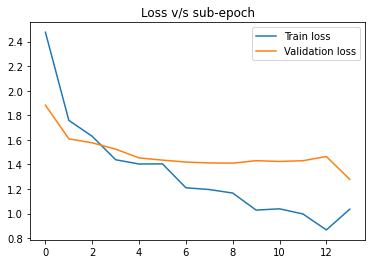

In [14]:
plt.plot([a['loss'] for a in train_stats], label='Train loss')
plt.plot([a['loss'] for a in val_stats], label='Validation loss')
plt.legend()
plt.title("Loss v/s sub-epoch")
plt.savefig(f'{outpath}/loss.png')

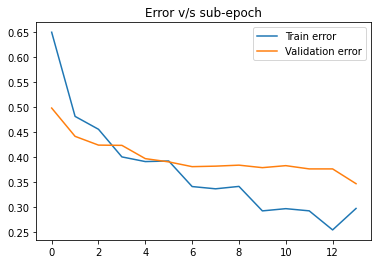

In [15]:
plt.plot([a['error'] for a in train_stats], label='Train error')
plt.plot([a['error'] for a in val_stats], label='Validation error')
plt.legend()
plt.title("Error v/s sub-epoch")
plt.savefig(f'{outpath}/error.png')

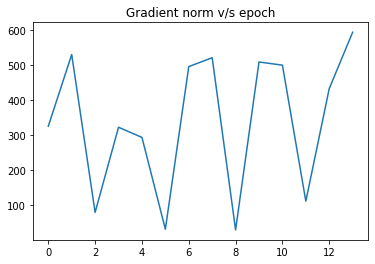

In [16]:
plt.plot([a['norm'] for a in train_stats], label='norm')
plt.title("Gradient norm v/s epoch")
plt.savefig(f'{outpath}/grad_norm.png')

In [17]:
preds = predict_model(model, dataloaders['test'])
preds.to_csv(f"/kaggle/working/submission.csv")

  0%|          | 0/180 [00:00<?, ?it/s]